In [1]:
import numpy as np
import pandas as pd

In [2]:
data=pd.read_csv('data_mermin_2018-07-06.csv',sep=';')
data.head()

,backend_name,date,results
0,ibmqx5,2018-07-06T05:47:54.506Z,"{'0000000000000000': 244, '0000000000000001': ..."
1,ibmqx5,2018-07-06T05:47:54.630Z,"{'0000000000000000': 90, '0000000000000001': 2..."
2,ibmqx5,2018-07-06T05:47:54.777Z,"{'0000000000000000': 109, '0000000000000001': ..."
3,ibmqx5,2018-07-06T05:47:54.917Z,"{'0000000000000000': 79, '0000000000000001': 2..."
4,ibmqx5,2018-07-06T05:47:29.977Z,"{'0000000000000000': 254, '0000000000000001': ..."


In [3]:
#filter only mermin jobs
data=data.query('date>"2018-07-06"')

In [4]:
data['obs']=np.tile(['XXX', 'YYX', 'YXY', 'XYY'],int(data.shape[0]/4))
data['index']=np.flip(np.repeat(range(int(data.shape[0]/4)),4),0)
data=data.rename(columns={'backend_name':'backend'})

In [5]:
results=data.results.map(eval).apply(pd.Series)
results=results.fillna(0)

In [6]:
data['X000']=results['0000000000000000']+results['00000']
data['X001']=results['0000000000000001']+results['00001']
data['X010']=results['0000000000000010']+results['00010']
data['X011']=results['0000000000000011']+results['00011']
data['X100']=results['1000000000000000']+results['00100']
data['X101']=results['1000000000000001']+results['00101']
data['X110']=results['1000000000000010']+results['00110']
data['X111']=results['1000000000000011']+results['00111']

In [7]:
data['measurement']=(data.X000+data.X011+data.X101+data.X110-data.X001-data.X010-data.X100-data.X111)/1024

In [8]:
data=data.drop('results',1)
data.head()

,backend,date,obs,index,X000,X001,X010,X011,X100,X101,X110,X111,measurement
0,ibmqx5,2018-07-06T05:47:54.506Z,XXX,577,244.0,66.0,66.0,175.0,75.0,181.0,205.0,12.0,0.572266
1,ibmqx5,2018-07-06T05:47:54.630Z,YYX,577,90.0,226.0,192.0,33.0,212.0,49.0,61.0,161.0,-0.544922
2,ibmqx5,2018-07-06T05:47:54.777Z,YXY,577,109.0,208.0,212.0,33.0,198.0,62.0,39.0,163.0,-0.525391
3,ibmqx5,2018-07-06T05:47:54.917Z,XYY,577,79.0,200.0,208.0,47.0,211.0,49.0,39.0,191.0,-0.582031
4,ibmqx5,2018-07-06T05:47:29.977Z,XXX,576,254.0,79.0,48.0,165.0,85.0,203.0,177.0,13.0,0.560547


In [9]:
mermin_obs={'XXX':-1, 'YYX':1, 'YXY':1, 'XYY':1}

In [10]:
data['mermin']=data.obs.map(mermin_obs)*data.measurement

In [11]:
agg_data=data.groupby(['index','backend']).agg({'mermin':'sum','date':'max'})
agg_data=agg_data.reset_index()
agg_data.head()

,index,backend,mermin,date
0,0,ibmqx5,-0.080078,2018-07-06T00:01:23.899Z
1,1,ibmqx5,0.017578,2018-07-06T00:01:23.515Z
2,2,ibmqx5,0.292969,2018-07-06T00:01:23.075Z
3,3,ibmqx5,0.322266,2018-07-06T00:01:22.477Z
4,4,ibmqx5,0.199219,2018-07-06T00:01:21.937Z


In [12]:
from ggplot import *

C:\Users\Alicja\Anaconda3\lib\site-packages\ggplot\utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
C:\Users\Alicja\Anaconda3\lib\site-packages\ggplot\stats\smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp


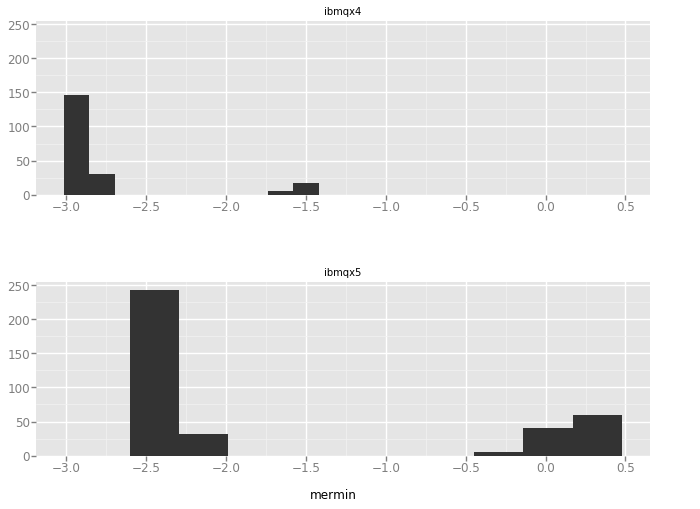

<ggplot: (143177531291)>

In [13]:
ggplot(aes(x='mermin'),data=agg_data)+geom_histogram(20)+facet_wrap('backend')

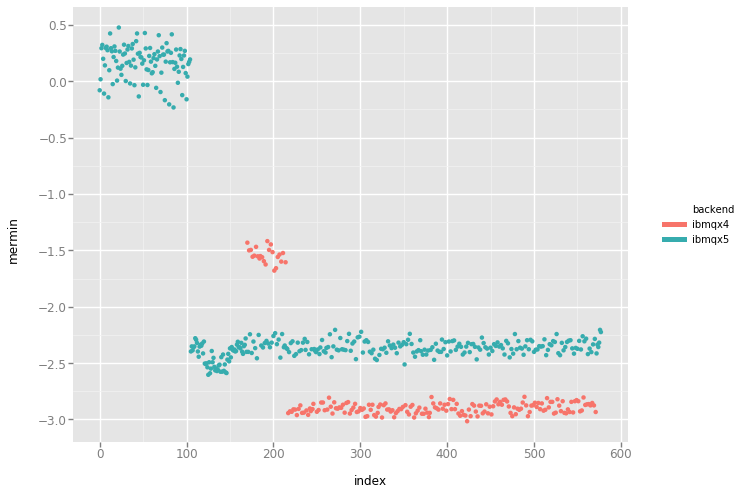

<ggplot: (-9223371893677027675)>

In [14]:
ggplot(aes(x='index',y='mermin',color='backend'),data=agg_data)+geom_point()

In [17]:
summary=agg_data.assign(
    realism_violated=agg_data.mermin<-2,number_of_experiments=1
).groupby('backend').agg(
    {'realism_violated':'sum','number_of_experiments':'sum'}
).reset_index()
summary['realism_violated']=summary.realism_violated.astype('int')
summary['percent']=summary.realism_violated/summary.number_of_experiments
summary

,backend,realism_violated,number_of_experiments,percent
0,ibmqx4,176,199,0.884422
1,ibmqx5,274,379,0.722955
